# Data extraction

## Setup

We need to:

1. Authenticate with Google.
2. Import libraries.
3. Set the `project-id` which will be used for billing query costs. Query costs for this tutorial are typically ~0.01 - 0.05 USD.

In [2]:
# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# the below variables are used throughout the notebook - do not change them!
subject_ids = [10000032, 10001884, 10002223, 10002495, 10002443, 10003400, 10005866]
id_str = ','.join([str(s) for s in subject_ids])

# You only need to authenticate once per session.
auth.authenticate_user()

In [3]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# below imports are used for pretty pandas dataframes and plots
from IPython.display import display, HTML
%matplotlib inline
plt.style.use('ggplot')

# Set up environment variables
project_id = 'kind-lab'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
    return pd.io.gbq.read_gbq(
        query,
        project_id=project_id,
        dialect="standard"
    )

if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project at the top of this cell.')

# test it works
df = run_query("""
SELECT *
FROM `physionet-data.mimic_core.patients`
WHERE subject_id = 10012853
""")
assert df.shape[0] >= 1, 'unable to query MIMIC!'
display(df)

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10012853,F,91,2175,2014 - 2016,NaT


In [4]:
# the below variables are used throughout the notebook. The file control.xlsx contains the information of the table and itemid used for each covariate

# itemids linked to chartevents
item_ids = [220052, 220045, 220227, 220050, 220051, 220210, 223762, 227013, 228232, 
            223835, 220546, 220228, 220545, 220615, 225690, 225651, 227467, 227466, 
            220587, 225612, 220621, 227442, 225624, 220635, 220602, 227446, 227429, 
            227468, 227444, 220580, 227443, 224719, 229571]
itemid_str = ','.join([str(s) for s in item_ids])


# itemids linked to labevents
labitem_ids = [50813, 50893, 51288, 50820, 50818, 50802]
labitemid_str = ','.join([str(s) for s in labitem_ids])

# Cohort MIMIC-IV and Summary Metrics

In [5]:
# Exclusion columns that we will use to create our cohort. stay_ids
df = run_query(f'''
SELECT ie.subject_id, ie.hadm_id, ie.stay_id
-- DATE_DIFF truncates hour difference so the exlusions are as follows
, CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 10 THEN 1 ELSE 0 END AS exclude_short_stay
, CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
, CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
, CASE WHEN DATE_DIFF(sep.sofa_time, ie.intime, HOUR) < 4 THEN 1 ELSE 0 END AS exclude_early_sepsis
FROM `physionet-data.mimic_icu.icustays` ie
INNER JOIN `physionet-data.mimic_derived.age` age
    ON ie.hadm_id = age.hadm_id
LEFT JOIN `physionet-data.mimic_derived.sepsis3` sep
    ON ie.stay_id = sep.stay_id
''')
display(df)

,subject_id,hadm_id,stay_id,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,16233333,20104005,39550370,0,0,0,0
1,18818836,25852913,34879697,0,0,0,0
2,10474526,21021060,30384015,0,0,0,1
3,11245028,27889421,33064307,0,0,0,0
4,19856829,23266513,38811029,0,0,0,0
...,...,...,...,...,...,...,...
76535,16464652,21685914,39045781,0,0,0,1
76536,18451791,28897092,32688519,0,0,0,0
76537,17715495,20406663,38915774,0,0,0,1
76538,14123938,26523563,39332229,0,0,0,0


In [6]:
# Exclusion columns that we will use to create our cohort. This is using subject_ids to find out the characteristics of the population.
df = run_query(f'''
SELECT ie.subject_id
, MAX(age.anchor_age) as age
-- Binary outcome for gender Male = 1, Female = 0
, CASE WHEN MAX(pt.gender) = 'M' THEN 1 ELSE 0 END as gender
, MAX(adm.hospital_expire_flag) as mortality
, AVG(ie.los)*24 as los
, AVG(sep.sofa_score) as sofa
, MAX(CASE WHEN sep.sepsis3 = True AND sep.sofa_time > ie.intime AND sep.sofa_time < ie.outtime THEN 1 ELSE 0 END) AS exclude_sepsis
-- DATE_DIFF truncates hour difference so the exclusions are as follows
, MAX(CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 10 THEN 1 ELSE 0 END) AS exclude_short_stay
, MAX(CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END) AS exclude_long_stay
, MAX(CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END) AS exclude_non_adult
, MAX(CASE WHEN DATE_DIFF(sep.sofa_time, ie.intime, HOUR) < 4 THEN 1 ELSE 0 END) AS exclude_early_sepsis
FROM `physionet-data.mimic_icu.icustays` ie
LEFT JOIN `physionet-data.mimic_derived.age` age
    ON ie.hadm_id = age.hadm_id
LEFT JOIN `physionet-data.mimic_derived.sepsis3` sep
    ON ie.stay_id = sep.stay_id
LEFT JOIN `physionet-data.mimic_core.patients` pt
    ON ie.subject_id = pt.subject_id
LEFT JOIN `physionet-data.mimic_core.admissions` adm
    ON ie.subject_id = adm.subject_id
GROUP BY ie.subject_id
''')
display(df)

,subject_id,age,gender,mortality,los,sofa,exclude_sepsis,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,11855128,83,0,0,44.574514,2.333333,1,0,0,0,1
1,19585869,67,0,0,171.333264,3.222222,1,0,1,0,1
2,13819466,53,1,1,174.316667,3.666667,1,0,0,0,1
3,18829223,76,0,0,232.947593,2.333333,1,0,0,0,0
4,11751107,61,0,0,111.788333,2.600000,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
53145,13108511,52,0,0,152.076250,9.000000,1,0,0,0,1
53146,14634884,91,0,1,27.761944,9.000000,1,0,0,0,1
53147,11634175,71,0,1,76.660000,9.000000,1,0,0,0,1
53148,15301848,23,1,0,72.833889,9.000000,1,0,0,0,1


In [7]:
# Cohort after length of stay exclusions
df_excl_length_stay = df[(df['exclude_long_stay']==0) & (df['exclude_short_stay']==0)]
df_excl_length_stay

,subject_id,age,gender,mortality,los,sofa,exclude_sepsis,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,11855128,83,0,0,44.574514,2.333333,1,0,0,0,1
2,13819466,53,1,1,174.316667,3.666667,1,0,0,0,1
3,18829223,76,0,0,232.947593,2.333333,1,0,0,0,0
5,18080257,65,1,1,74.931944,10.000000,1,0,0,0,0
8,10232271,56,0,0,76.981111,6.000000,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
53145,13108511,52,0,0,152.076250,9.000000,1,0,0,0,1
53146,14634884,91,0,1,27.761944,9.000000,1,0,0,0,1
53147,11634175,71,0,1,76.660000,9.000000,1,0,0,0,1
53148,15301848,23,1,0,72.833889,9.000000,1,0,0,0,1


In [8]:
# Cohort after development of sepsis early in the ICU stay
df_excl_length_stay_and_early_sepsis = df_excl_length_stay[df_excl_length_stay['exclude_early_sepsis']==0]
df_excl_length_stay_and_early_sepsis

,subject_id,age,gender,mortality,los,sofa,exclude_sepsis,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
3,18829223,76,0,0,232.947593,2.333333,1,0,0,0,0
5,18080257,65,1,1,74.931944,10.000000,1,0,0,0,0
18,17284612,56,0,0,159.933704,12.000000,1,0,0,0,0
24,11685699,79,1,1,86.617659,3.333333,1,0,0,0,0
39,18754935,68,1,1,102.989537,5.500000,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
53116,13900333,88,1,0,378.830278,9.000000,1,0,0,0,0
53127,11071537,81,1,0,71.265556,9.000000,1,0,0,0,0
53131,16238322,65,1,0,125.096944,9.000000,1,0,0,0,0
53132,15796318,66,1,0,42.366667,9.000000,1,0,0,0,0


In [9]:
df_excl_length_stay_and_early_sepsis[df_excl_length_stay_and_early_sepsis['exclude_sepsis'] == 0]

,subject_id,age,gender,mortality,los,sofa,exclude_sepsis,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
2674,16256226,49,0,0,41.998750,NaN,0,0,0,0,0
2676,14609218,69,0,0,163.808889,NaN,0,0,0,0,0
2677,12687112,57,1,0,88.124444,NaN,0,0,0,0,0
2678,18190935,57,0,1,61.675093,NaN,0,0,0,0,0
2679,10404210,46,0,0,47.675278,NaN,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
28808,19632565,59,0,1,150.013333,NaN,0,0,0,0,0
28809,12762280,77,0,0,48.502222,NaN,0,0,0,0,0
29958,16085209,40,1,0,15.621944,2.0,0,0,0,0,0
36744,17425595,20,1,0,16.421944,2.0,0,0,0,0,0


In [10]:
summary_metrics_df = df_excl_length_stay_and_early_sepsis.iloc[:,1:7]

Summary of FullCohort Main Characteristics

In [11]:
summary_metrics_df.describe()

,age,gender,mortality,los,sofa,exclude_sepsis
count,34935.000000,34935.000000,34935.000000,34935.000000,9957.000000,34935.000000
mean,62.637899,0.557664,0.086131,61.398479,3.253027,0.284929
std,17.622286,0.496671,0.280562,61.221308,1.779668,0.451387
min,18.000000,0.000000,0.000000,9.143889,2.000000,0.000000
25%,52.000000,0.000000,0.000000,26.004722,2.000000,0.000000
50%,65.000000,1.000000,0.000000,41.791296,3.000000,0.000000
75%,76.000000,1.000000,0.000000,71.455917,4.000000,1.000000
max,91.000000,1.000000,1.000000,479.390833,20.000000,1.000000


Summary of Septic Cohort Main Characteristics

In [12]:
summary_metrics_df[summary_metrics_df['exclude_sepsis'] == 1].describe()

,age,gender,mortality,los,sofa,exclude_sepsis
count,9954.000000,9954.000000,9954.000000,9954.000000,9954.000000,9954.0
mean,64.564698,0.589210,0.129998,94.346585,3.253405,1.0
std,16.396520,0.492002,0.336318,87.458307,1.779803,0.0
min,18.000000,0.000000,0.000000,9.486944,2.000000,1.0
25%,55.000000,0.000000,0.000000,34.289618,2.000000,1.0
50%,66.000000,1.000000,0.000000,60.993889,3.000000,1.0
75%,77.000000,1.000000,0.000000,118.419028,4.000000,1.0
max,91.000000,1.000000,1.000000,479.390833,20.000000,1.0


Summary of Non-Septic Cohort Main Characteristics

In [13]:
summary_metrics_df[summary_metrics_df['exclude_sepsis'] == 0].describe()

,age,gender,mortality,los,sofa,exclude_sepsis
count,24981.000000,24981.000000,24981.000000,24981.000000,3.0,24981.0
mean,61.870141,0.545094,0.068652,48.269884,2.0,0.0
std,18.030615,0.497972,0.252867,39.862006,0.0,0.0
min,18.000000,0.000000,0.000000,9.143889,2.0,0.0
25%,51.000000,0.000000,0.000000,23.809444,2.0,0.0
50%,64.000000,1.000000,0.000000,36.030278,2.0,0.0
75%,76.000000,1.000000,0.000000,57.951389,2.0,0.0
max,91.000000,1.000000,1.000000,475.392500,2.0,0.0


## Chartevents

Test with only 2 stay_ids

In [16]:
# Getting our variables of interest which are linked to chartevents following exclusions  
df_ce = run_query(f'''
 
WITH cohort AS
-- cohort identifiers, exclusion columns and auxiliary columns to build the dataframe in the format required by the model
(
  SELECT ie.subject_id
  , ie.hadm_id
  , ie.stay_id 
  , ie.intime
  , ie.outtime
  -- DATE_DIFF truncates hour difference
  , DATE_DIFF(ie.outtime, ie.intime, HOUR)+1 AS los
  -- Since 480 is the maximum time in hours where sepsis can be developed in the patient since the period under study is less than 
  -- 20 days I'll use 1000 as a number to identify patients that didn't develop sepsis.
  , IFNULL(DATE_DIFF(sep.sofa_time, ie.intime, HOUR), 1000) AS time_to_sepsis
  , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 10 THEN 1 ELSE 0 END AS exclude_short_stay
  , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
  , CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
  , CASE WHEN DATE_DIFF(sep.sofa_time, ie.intime, HOUR) < 4 THEN 1 ELSE 0 END AS exclude_early_sepsis
  FROM `physionet-data.mimic_icu.icustays` ie
  INNER JOIN `physionet-data.mimic_derived.age` age
      ON ie.hadm_id = age.hadm_id
  LEFT JOIN `physionet-data.mimic_derived.sepsis3` sep
      ON ie.stay_id = sep.stay_id
  WHERE ie.stay_id IN (37464945, 30000153)
)
, chartevents_covariates AS
(
  SELECT ce.stay_id 
  -- We need to follow lifelines data format, this is why we create stop_time
  , DATE_DIFF(ce.charttime, ct.intime, HOUR)+1 AS stop_time
  , ce.itemid
  , ce.charttime
  , ci.label
  , ce.value
  , ce.valuenum
  , ce.valueuom
  FROM `physionet-data.mimic_icu.chartevents`ce
  LEFT JOIN `physionet-data.mimic_icu.d_items` ci
    ON ce.itemid = ci.itemid
  LEFT JOIN cohort ct
    ON ct.stay_id = ce.stay_id
  -- List of itemids previously searched on BigQuery
  WHERE ce.itemid IN ({itemid_str})
    -- Filter exclusions
  AND ct.exclude_early_sepsis = 0
  AND ct.exclude_short_stay = 0 
  AND ct.exclude_long_stay = 0
  AND ct.exclude_non_adult = 0
  ORDER BY ce.charttime
)
, other_covariates AS
(
  SELECT ie.subject_id
  , ie.stay_id
  , ie.last_careunit as care_unit
  , da.age
  , dc.charlson_comorbidity_index as cci
  FROM `physionet-data.mimic_icu.icustays` ie
  LEFT JOIN `physionet-data.mimic_derived.age`da
    ON ie.subject_id = da.subject_id
  LEFT JOIN `physionet-data.mimic_derived.charlson` dc
    ON ie.subject_id = dc.subject_id
)

SELECT ct.subject_id
, ct.hadm_id
, ct.stay_id 
, oc.age
, oc.cci
, ct.intime
, ct.outtime
, ct.los
, ct.time_to_sepsis
, cc.stop_time-1 AS start_time
, cc.stop_time
-- Since we will create 1-hour bins and sometimes the measurments are taken with more frequency, we need to 
-- get the final measurement within the hour
, LAST_VALUE(cc.valuenum) OVER (PARTITION BY cc.stay_id, cc.stop_time ORDER BY cc.label) as last_measurement_hour
, cc.itemid
, cc.charttime
, cc.label
, cc.value
, cc.valuenum
, cc.valueuom
FROM cohort ct
LEFT JOIN chartevents_covariates cc
  ON ct.stay_id = cc.stay_id
LEFT JOIN other_covariates oc
  ON ct.stay_id = oc.stay_id
-- For some reason there are cases where the charttime is before the intime so I filtered out those cases
WHERE cc.stop_time > 0  
-- We're only interested in patients while they're free of sepsis
AND ct.time_to_sepsis >= cc.stop_time
ORDER BY cc.stop_time
''')

display(df_ce)

,subject_id,hadm_id,stay_id,age,cci,intime,outtime,los,time_to_sepsis,start_time,stop_time,last_measurement_hour,itemid,charttime,label,value,valuenum,valueuom
0,15149410,23158991,37464945,60,6,2185-12-27 02:25:29,2185-12-28 18:08:15,41,13,0,1,94.0,220045,2185-12-27 02:25:00,Heart Rate,94,94.0,bpm
1,15149410,23158991,37464945,60,6,2185-12-27 02:25:29,2185-12-28 18:08:15,41,13,0,1,22.0,220210,2185-12-27 02:25:00,Respiratory Rate,22,22.0,insp/min
2,12466550,23998182,30000153,61,3,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,0,1,100.0,220045,2174-09-29 12:06:00,Heart Rate,100,100.0,bpm
3,12466550,23998182,30000153,61,3,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,0,1,35.0,220545,2174-09-29 12:27:00,Hematocrit (serum),35,35.0,%
4,12466550,23998182,30000153,61,3,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,0,1,50.0,223835,2174-09-29 12:01:00,Inspired O2 Fraction,100,100.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,12466550,23998182,30000153,61,3,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,37,38,21.0,220210,2174-10-01 01:00:00,Respiratory Rate,21,21.0,insp/min
259,12466550,23998182,30000153,61,3,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,38,39,94.0,220045,2174-10-01 02:00:00,Heart Rate,94,94.0,bpm
260,12466550,23998182,30000153,61,3,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,38,39,11.0,220210,2174-10-01 02:00:00,Respiratory Rate,11,11.0,insp/min
261,12466550,23998182,30000153,61,3,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,39,40,97.0,220045,2174-10-01 03:00:00,Heart Rate,97,97.0,bpm


## Labevents

In [17]:
# Getting our variables of interest which are linked to labevents following exclusions  
df_le = run_query(f'''
 
WITH cohort AS
-- cohort identifiers, exclusion columns and auxiliary columns to build the dataframe in the format required by the model
(
  SELECT ie.subject_id
  , ie.hadm_id
  , ie.stay_id 
  , ie.intime
  , ie.outtime
  -- DATE_DIFF truncates hour difference
  , DATE_DIFF(ie.outtime, ie.intime, HOUR)+1 AS los
  -- Since 480 is the maximum time in hours where sepsis can be developed in the patient since the period under study is less than 
  -- 20 days I'll use 1000 as a number to identify patients that didn't develop sepsis.
  , IFNULL(DATE_DIFF(sep.sofa_time, ie.intime, HOUR), 1000) AS time_to_sepsis
  , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 10 THEN 1 ELSE 0 END AS exclude_short_stay
  , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
  , CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
  , CASE WHEN DATE_DIFF(sep.sofa_time, ie.intime, HOUR) < 4 THEN 1 ELSE 0 END AS exclude_early_sepsis
  FROM `physionet-data.mimic_icu.icustays` ie
  INNER JOIN `physionet-data.mimic_derived.age` age
      ON ie.hadm_id = age.hadm_id
  LEFT JOIN `physionet-data.mimic_derived.sepsis3` sep
      ON ie.stay_id = sep.stay_id
  WHERE ie.stay_id IN (37464945, 30000153)
)
, labevents_covariates AS
(
  SELECT le.hadm_id 
  -- We need to follow lifelines data format, this is why we create stop_time
  , DATE_DIFF(le.charttime, ct.intime, HOUR)+1 AS stop_time
  , le.itemid
  , le.charttime
  , li.label
  , le.value
  , le.valuenum
  , le.valueuom
  FROM `physionet-data.mimic_hosp.labevents` le
  LEFT JOIN `physionet-data.mimic_hosp.d_labitems` li
    ON le.itemid = li.itemid
  LEFT JOIN cohort ct
    -- we use hadm_id to join since there's no stay_id on labevents but we deal with this with a filter 
    -- on the charttimes
    ON ct.hadm_id = le.hadm_id
  -- List of itemids previously searched on BigQuery
  WHERE le.itemid IN ({labitemid_str}) 
  ORDER BY le.charttime
)
, other_covariates AS
(
  SELECT ie.subject_id
  , ie.stay_id
  , ie.last_careunit as care_unit
  , da.age
  , dc.charlson_comorbidity_index as cci
  FROM `physionet-data.mimic_icu.icustays` ie
  LEFT JOIN `physionet-data.mimic_derived.age`da
    ON ie.subject_id = da.subject_id
  LEFT JOIN `physionet-data.mimic_derived.charlson` dc
    ON ie.subject_id = dc.subject_id
)

SELECT ct.subject_id
, ct.hadm_id
, ct.stay_id 
, oc.age
, oc.cci
, ct.intime
, ct.outtime
, ct.los
, ct.time_to_sepsis
, lc.stop_time-1 AS start_time
, lc.stop_time
-- Since we will create 1-hour bins and sometimes the measurments are taken with more frequency, we need to 
-- get the final measurement within the hour
, LAST_VALUE(lc.valuenum) OVER (PARTITION BY ct.stay_id, lc.stop_time ORDER BY lc.label) as last_measurement_hour
, lc.itemid
, lc.charttime
, lc.label
, lc.value
, lc.valuenum
, lc.valueuom
FROM cohort ct
LEFT JOIN labevents_covariates lc
  ON ct.hadm_id = lc.hadm_id
LEFT JOIN other_covariates oc
  ON ct.stay_id = oc.stay_id
-- For some reason there are cases where the charttime is before the intime so I filtered out those cases
WHERE lc.stop_time > 0  
AND ct.intime < lc.charttime 
AND lc.charttime < ct.outtime
-- We're only interested in patients while they're free of sepsis
AND ct.time_to_sepsis >= lc.stop_time
-- Filter exclusions
AND ct.exclude_early_sepsis = 0
AND ct.exclude_short_stay = 0 
AND ct.exclude_long_stay = 0
AND ct.exclude_non_adult = 0
ORDER BY lc.stop_time
''')

display(df_le)

,subject_id,hadm_id,stay_id,age,cci,intime,outtime,los,time_to_sepsis,start_time,stop_time,last_measurement_hour,itemid,charttime,label,value,valuenum,valueuom
0,12466550,23998182,30000153,61,3,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,1,2,-3.00,50802,2174-09-29 13:27:00,Base Excess,-3,-3.00,mEq/L
1,12466550,23998182,30000153,61,3,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,1,2,1.30,50813,2174-09-29 13:27:00,Lactate,1.3,1.30,mmol/L
2,12466550,23998182,30000153,61,3,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,1,2,45.00,50818,2174-09-29 13:27:00,pCO2,45,45.00,mm Hg
3,12466550,23998182,30000153,61,3,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,1,2,7.30,50820,2174-09-29 13:27:00,pH,7.30,7.30,units
4,12466550,23998182,30000153,61,3,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,2,3,-3.00,50802,2174-09-29 14:07:00,Base Excess,-3,-3.00,mEq/L
5,12466550,23998182,30000153,61,3,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,2,3,2.10,50813,2174-09-29 14:07:00,Lactate,2.1,2.10,mmol/L
6,12466550,23998182,30000153,61,3,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,2,3,45.00,50818,2174-09-29 14:07:00,pCO2,45,45.00,mm Hg
7,12466550,23998182,30000153,61,3,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,2,3,7.30,50820,2174-09-29 14:07:00,pH,7.30,7.30,units
8,15149410,23158991,37464945,60,6,2185-12-27 02:25:29,2185-12-28 18:08:15,41,13,2,3,9.30,50893,2185-12-27 04:53:00,"Calcium, Total",9.3,9.30,mg/dL
9,12466550,23998182,30000153,61,3,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,3,4,7.40,50893,2174-09-29 15:37:00,"Calcium, Total",7.4,7.40,mg/dL


In [18]:
# Concatenate dataframes
df = pd.concat([df_ce, df_le])
df

,subject_id,hadm_id,stay_id,age,cci,intime,outtime,los,time_to_sepsis,start_time,stop_time,last_measurement_hour,itemid,charttime,label,value,valuenum,valueuom
0,15149410,23158991,37464945,60,6,2185-12-27 02:25:29,2185-12-28 18:08:15,41,13,0,1,94.00,220045,2185-12-27 02:25:00,Heart Rate,94,94.00,bpm
1,15149410,23158991,37464945,60,6,2185-12-27 02:25:29,2185-12-28 18:08:15,41,13,0,1,22.00,220210,2185-12-27 02:25:00,Respiratory Rate,22,22.00,insp/min
2,12466550,23998182,30000153,61,3,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,0,1,100.00,220045,2174-09-29 12:06:00,Heart Rate,100,100.00,bpm
3,12466550,23998182,30000153,61,3,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,0,1,35.00,220545,2174-09-29 12:27:00,Hematocrit (serum),35,35.00,%
4,12466550,23998182,30000153,61,3,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,0,1,50.00,223835,2174-09-29 12:01:00,Inspired O2 Fraction,100,100.00,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,15149410,23158991,37464945,60,6,2185-12-27 02:25:29,2185-12-28 18:08:15,41,13,10,11,7.38,50820,2185-12-27 12:31:00,pH,7.38,7.38,units
27,15149410,23158991,37464945,60,6,2185-12-27 02:25:29,2185-12-28 18:08:15,41,13,12,13,0.00,50802,2185-12-27 14:45:00,Base Excess,0,0.00,mEq/L
28,15149410,23158991,37464945,60,6,2185-12-27 02:25:29,2185-12-28 18:08:15,41,13,12,13,43.00,50818,2185-12-27 14:45:00,pCO2,43,43.00,mm Hg
29,15149410,23158991,37464945,60,6,2185-12-27 02:25:29,2185-12-28 18:08:15,41,13,12,13,7.37,50820,2185-12-27 14:45:00,pH,7.37,7.37,units


In [33]:
# Pivoting the table to transform it to wide format
base_df = pd.pivot_table(df, index=['stay_id', 'start_time', 'stop_time', 'time_to_sepsis', 'los', 'age', 'cci'], 
                         columns='label', values='last_measurement_hour').reset_index()
base_df

label,stay_id,start_time,stop_time,time_to_sepsis,los,age,cci,AST,Arterial Blood Pressure diastolic,Arterial Blood Pressure mean,...,Inspired O2 Fraction,Lactate,Magnesium,PTT,Potassium (serum),Respiratory Rate,Troponin-T,WBC,pCO2,pH
0,30000153,0,1,1000,40,61,3,NaN,NaN,NaN,...,50.0,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN
1,30000153,1,2,1000,40,61,3,NaN,72.0,NaN,...,NaN,1.3,NaN,NaN,NaN,16.0,NaN,NaN,45.0,7.30
2,30000153,2,3,1000,40,61,3,NaN,61.0,80.0,...,NaN,2.1,NaN,NaN,NaN,16.0,NaN,NaN,45.0,7.30
3,30000153,3,4,1000,40,61,3,NaN,65.0,84.0,...,50.0,NaN,1.5,25.3,4.4,14.0,0.01,17.0,NaN,NaN
4,30000153,4,5,1000,40,61,3,NaN,55.0,71.0,...,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,42.0,7.31
5,30000153,5,6,1000,40,61,3,NaN,56.0,71.0,...,50.0,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN
6,30000153,6,7,1000,40,61,3,NaN,63.0,83.0,...,NaN,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN
7,30000153,7,8,1000,40,61,3,NaN,68.0,91.0,...,NaN,NaN,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN
8,30000153,8,9,1000,40,61,3,NaN,67.0,83.0,...,40.0,NaN,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN
9,30000153,9,10,1000,40,61,3,NaN,67.0,87.0,...,NaN,NaN,NaN,NaN,NaN,22.0,NaN,NaN,NaN,NaN


In [39]:
# Creating a column that tells us when did sepsis start developing
base_df['sepsis'] = base_df.apply(lambda x: False if x.time_to_sepsis > x.stop_time else True, axis=1)
base_df

label,stay_id,start_time,stop_time,time_to_sepsis,los,age,cci,AST,Arterial Blood Pressure diastolic,Arterial Blood Pressure mean,...,Magnesium,PTT,Potassium (serum),Respiratory Rate,Troponin-T,WBC,pCO2,pH,sepsis,start
0,30000153,0,1,1000,40,61,3,NaN,NaN,NaN,...,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,False,0.0
1,30000153,1,2,1000,40,61,3,NaN,72.0,NaN,...,NaN,NaN,NaN,16.0,NaN,NaN,45.0,7.30,False,1.0
2,30000153,2,3,1000,40,61,3,NaN,61.0,80.0,...,NaN,NaN,NaN,16.0,NaN,NaN,45.0,7.30,False,2.0
3,30000153,3,4,1000,40,61,3,NaN,65.0,84.0,...,1.5,25.3,4.4,14.0,0.01,17.0,NaN,NaN,False,3.0
4,30000153,4,5,1000,40,61,3,NaN,55.0,71.0,...,NaN,NaN,NaN,16.0,NaN,NaN,42.0,7.31,False,4.0
5,30000153,5,6,1000,40,61,3,NaN,56.0,71.0,...,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,False,5.0
6,30000153,6,7,1000,40,61,3,NaN,63.0,83.0,...,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,False,6.0
7,30000153,7,8,1000,40,61,3,NaN,68.0,91.0,...,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,False,7.0
8,30000153,8,9,1000,40,61,3,NaN,67.0,83.0,...,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,False,8.0
9,30000153,9,10,1000,40,61,3,NaN,67.0,87.0,...,NaN,NaN,NaN,22.0,NaN,NaN,NaN,NaN,False,9.0


In [40]:
# Creating a different start column to account for the fact that sometimes there is missing information in a particular hour
base_df["start"] = 0
base_df.loc[(base_df['start_time'] > 0) & (base_df['stop_time'].diff() > 0), 'start'] = base_df['stop_time'] - base_df['stop_time'].diff()
base_df

label,stay_id,start_time,stop_time,time_to_sepsis,los,age,cci,AST,Arterial Blood Pressure diastolic,Arterial Blood Pressure mean,...,Magnesium,PTT,Potassium (serum),Respiratory Rate,Troponin-T,WBC,pCO2,pH,sepsis,start
0,30000153,0,1,1000,40,61,3,NaN,NaN,NaN,...,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,False,0.0
1,30000153,1,2,1000,40,61,3,NaN,72.0,NaN,...,NaN,NaN,NaN,16.0,NaN,NaN,45.0,7.30,False,1.0
2,30000153,2,3,1000,40,61,3,NaN,61.0,80.0,...,NaN,NaN,NaN,16.0,NaN,NaN,45.0,7.30,False,2.0
3,30000153,3,4,1000,40,61,3,NaN,65.0,84.0,...,1.5,25.3,4.4,14.0,0.01,17.0,NaN,NaN,False,3.0
4,30000153,4,5,1000,40,61,3,NaN,55.0,71.0,...,NaN,NaN,NaN,16.0,NaN,NaN,42.0,7.31,False,4.0
5,30000153,5,6,1000,40,61,3,NaN,56.0,71.0,...,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,False,5.0
6,30000153,6,7,1000,40,61,3,NaN,63.0,83.0,...,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,False,6.0
7,30000153,7,8,1000,40,61,3,NaN,68.0,91.0,...,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,False,7.0
8,30000153,8,9,1000,40,61,3,NaN,67.0,83.0,...,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,False,8.0
9,30000153,9,10,1000,40,61,3,NaN,67.0,87.0,...,NaN,NaN,NaN,22.0,NaN,NaN,NaN,NaN,False,9.0


In [41]:
# Fill missing values with the mean grouped by stay_id and drop irrelevant columns
final_df = base_df.copy().drop(['time_to_sepsis', 'los', 'start_time'], axis=1)
final_df.iloc[:,1:] = base_df.groupby("stay_id").transform(lambda x: x.fillna(x.mean())).drop(['time_to_sepsis', 'los', 'start_time'], axis=1)
final_df = final_df.dropna(axis=1)

In [37]:
pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Iteration 1: norm_delta = 0.14412, step_size = 0.95000, ll = -0.69315, newton_decrement = 0.43366, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.04708, step_size = 0.95000, ll = -0.22794, newton_decrement = 0.02787, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.01119, step_size = 0.95000, ll = -0.19786, newton_decrement = 0.00117, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00105, step_size = 1.00000, ll = -0.19667, newton_decrement = 0.00001, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -0.19666, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 50 periods, 2 subjects, 1 events>
         event col = 'sepsis'
         penalizer = 0.1
number of subjects = 2
 number of periods = 50
  number of events = 1
partial log-likelihood = -0.20
  time fit was run = 2022-08-02 17:25:50 UTC

---
                                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                 
age                                -0.11       0.90       1.09            -2.24             2.03                 0.11                 7.58
cci                                 0.04       1.04       0.36            -0.68             0.75                 0.51                 2.11
Arterial Blood Pressure diastolic   0.00       1.00       0.05            -0.09             0.09                 0.92                 1.10
Arterial Blood Pressure mean        0.00       1.00       0.04            -0.07             0.07                 0.93                 1.07
Arterial Blood Pressure systolic    0.00       1.00       0.03            -0.06             0.06                 0.94                 1.06
BUN                                -0.12       0.89       0.63            -1.34             1.11                 0.26                 3.03
Base Excess                         0.01       1.01       0.19            -0.36             0.38                 0.70                 1.46
Calcium, Total                      0.07       1.07       0.68            -1.26             1.40                 0.28                 4.04
Chloride (serum)                   -0.01       0.99       0.11            -0.23             0.22                 0.79                 1.24
Creatinine (serum)                 -1.03       0.36      10.58           -21.75            19.70                 0.00             3.60e+08
Fibrinogen                          0.01       1.01       0.05            -0.10             0.11                 0.90                 1.12
Glucose (serum)                     0.00       1.00       0.08            -0.16             0.16                 0.85                 1.18
HCO3 (serum)                        0.03       1.03       0.26            -0.49             0.54                 0.61                 1.72
Heart Rate                         -0.00       1.00       0.05            -0.09             0.08                 0.91                 1.09
Hematocrit (serum)                  0.01       1.01       0.14            -0.27             0.29                 0.77                 1.34
Hemoglobin                          0.04       1.04       0.44            -0.83             0.91                 0.44                 2.49
INR                                -0.00       1.00      13.28           -26.03            26.03                 0.00             2.02e+11
Inspired O2 Fraction                0.00       1.00       0.02            -0.04             0.04                 0.96                 1.04
Lactate                             0.16       1.18       1.72            -3.21             3.53                 0.04                34.22
Magnesium                           0.25       1.29       1.43            -2.55             3.06                 0.08                21.25
PTT                                 0.00       1.00       0.03            -0.06             0.06                 0.94                 1.06
Potassium (serum)                  -0.19       0.83       1.51            -3.15             2.77                 0.04                15.92
Respiratory Rate                    0.01       1.01       0.12            -0.22             0.24                 0.80                 1.27
Troponin-T                          1.56       4.74      15.56           -28.94            32.05                 0.00             8.30e+13
WBC                                -0.01       0.99       0.27            -0.53             0.51     

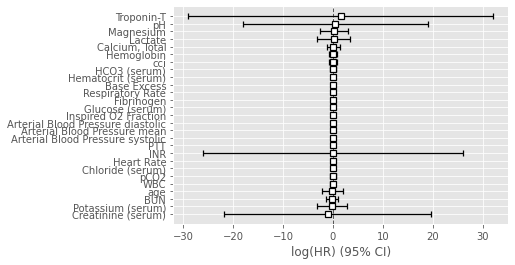

In [42]:
# Fitting the model
import lifelines
from lifelines import CoxTimeVaryingFitter
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(final_df, id_col="stay_id", event_col="sepsis", start_col="start", stop_col="stop_time", show_progress=True)
ctv.print_summary()
ctv.plot()

In [43]:
# We compare the existing model (with all the covariates) to the trivial model of no covariates using the likelihood ratio test.
ctv.log_likelihood_ratio_test()

<lifelines.StatisticalResult: None>
  degrees_freedom = 27
null_distribution = chi squared
        test_name = None

---
                           test_statistic    p  -log2(p)
log-likelihood ratio test            0.99 1.00      0.00

Attempting prediction

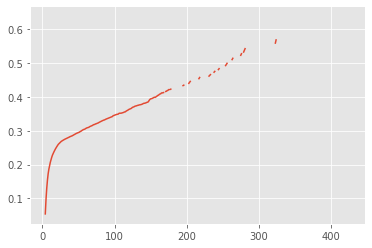

In [ ]:
b_hazard = pd.DataFrame({'baseline_hazard': 0}, index = np.arange(1, 480, 1))
b_hazard['baseline_hazard'] = ctv.baseline_cumulative_hazard_
b_hazard['baseline_hazard'].plot()

,baseline_hazard,stop_time
1,0.054309,1
2,0.054309,2
3,0.054309,3
4,0.054309,4
5,0.097317,5
...,...,...
475,0.638915,475
476,0.638915,476
477,0.638915,477
478,0.638915,478


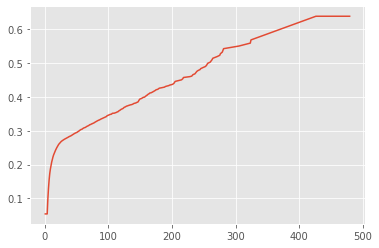

In [ ]:
b_hazard = b_hazard.interpolate(method='linear', limit_direction='both', axis=0)
b_hazard['baseline_hazard'].plot()
b_hazard['stop_time'] = b_hazard.index
b_hazard

In [ ]:
final_df_predict = final_df.copy()
final_df_predict['partial_hazard'] = ctv.predict_partial_hazard(final_df)
final_df_predict = final_df_predict.merge(b_hazard, left_on='stop_time', right_on='stop_time')
final_df_predict

,stay_id,stop_time,AST,Alkaline Phosphate,Ammonia,Arterial Blood Pressure diastolic,Arterial Blood Pressure mean,Arterial Blood Pressure systolic,Arterial O2 Saturation,BUN,...,Potassium (serum),Respiratory Rate,Temperature Celsius,Total Bilirubin,Troponin-T,WBC,sepsis,start,partial_hazard,baseline_hazard
0,30000153,1,288.519916,116.005081,48.408313,61.060349,80.948181,121.59453,314.801982,113.342843,...,49.447528,18.000000,36.945062,1.918957,81.124586,167.549846,False,0.0,1.489915,0.054309
1,30000213,1,288.519916,116.005081,48.408313,61.060349,80.948181,121.59453,314.801982,113.342843,...,49.447528,22.000000,36.945062,1.918957,81.124586,167.549846,False,0.0,0.985324,0.054309
2,30000646,1,288.519916,116.005081,48.408313,61.060349,80.948181,121.59453,314.801982,113.342843,...,49.447528,28.000000,36.945062,1.918957,81.124586,167.549846,False,0.0,0.998772,0.054309
3,30001336,1,38.000000,281.000000,48.408313,61.060349,80.948181,121.59453,314.801982,17.000000,...,4.200000,30.000000,36.945062,0.900000,1.600000,9.000000,False,0.0,1.121836,0.054309
4,30001656,1,288.519916,116.005081,48.408313,61.060349,80.948181,121.59453,314.801982,113.342843,...,49.447528,16.000000,36.945062,1.918957,81.124586,167.549846,False,0.0,1.490267,0.054309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2069000,32452165,467,288.519916,116.005081,48.408313,61.060349,80.948181,121.59453,314.801982,113.342843,...,49.447528,16.000000,36.945062,1.918957,81.124586,167.549846,False,466.0,1.000409,0.638915
2069001,38710393,467,288.519916,116.005081,48.408313,61.060349,80.948181,121.59453,314.801982,113.342843,...,49.447528,15.000000,36.945062,1.918957,81.124586,167.549846,False,466.0,1.000545,0.638915
2069002,32452165,468,288.519916,116.005081,48.408313,61.060349,80.948181,121.59453,314.801982,113.342843,...,49.447528,13.000000,36.945062,1.918957,81.124586,167.549846,False,467.0,1.000818,0.638915
2069003,36054435,468,30.000000,86.000000,48.408313,61.060349,80.948181,121.59453,314.801982,53.000000,...,4.600000,18.994809,36.945062,0.700000,81.124586,16.000000,False,343.0,0.961301,0.638915


In [ ]:
((final_df_predict['partial_hazard'] * final_df_predict['baseline_hazard']) > 0.5)

0          False
1          False
2          False
3          False
4          False
           ...  
2069000     True
2069001     True
2069002     True
2069003     True
2069004     True
Length: 2069005, dtype: bool

## Labevents

In [210]:
# Getting our variables of interest which are linked to labevents following exclusions  

df = run_query(f'''

WITH labevents_cohort AS
  (
  WITH cohort AS
  (
    SELECT ie.subject_id, 
    ie.hadm_id, 
    ie.stay_id, 
    ie.intime, 
    ie.outtime
    -- DATE_DIFF truncates hour difference
    , DATE_DIFF(ie.outtime, ie.intime, HOUR)+1 AS los
    -- Since 480 is the maximum time in hours where sepsis can be developed in the patient since the period under study is less than 
    -- 20 days I'll use 1000 as a number to identify patients that didn't develop sepsis.
    , IFNULL(DATE_DIFF(sep.sofa_time, ie.intime, HOUR), 1000) AS time_to_sepsis
    , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 10 THEN 1 ELSE 0 END AS exclude_short_stay
    , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
    , CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
    , CASE WHEN DATE_DIFF(sep.sofa_time, ie.intime, HOUR) < 4 THEN 1 ELSE 0 END AS exclude_early_sepsis
    FROM `physionet-data.mimic_icu.icustays` ie
    INNER JOIN `physionet-data.mimic_derived.age` age
        ON ie.hadm_id = age.hadm_id
    LEFT JOIN `physionet-data.mimic_derived.sepsis3` sep
        ON ie.stay_id = sep.stay_id
    WHERE ie.stay_id IN (37464945, 30000153)
  )
  SELECT ct.subject_id, ct.hadm_id, ct.stay_id,  
  ct.intime,
  ct.outtime,
  ct.los,
  ct.time_to_sepsis,
  DATE_DIFF(le.charttime, ct.intime, HOUR)+1 AS stop_time,
  le.itemid,
  le.charttime,
  li.label,
  le.value,
  le.valuenum,
  le.valueuom,
  ct.exclude_short_stay, 
  ct.exclude_long_stay, 
  ct.exclude_non_adult, 
  ct.exclude_early_sepsis
  FROM cohort ct
  LEFT JOIN `physionet-data.mimic_hosp.labevents` le
    ON ct.hadm_id = le.hadm_id
  LEFT JOIN `physionet-data.mimic_hosp.d_labitems` li
    ON le.itemid = li.itemid
  WHERE le.itemid IN ({labitemid_str}) AND ct.intime < le.charttime 
  AND le.charttime < ct.outtime
  AND ct.exclude_early_sepsis = 0
  AND ct.exclude_short_stay = 0 
  AND ct.exclude_long_stay = 0
  AND ct.exclude_non_adult = 0
  ORDER BY le.charttime
  )
SELECT lc.subject_id, 
lc.hadm_id, 
lc.stay_id,  
lc.intime,
lc.outtime,
lc.los,
lc.time_to_sepsis,
lc.stop_time-1 AS start_time,
lc.stop_time,
LAST_VALUE(lc.valuenum) OVER (PARTITION BY lc.stay_id, lc.stop_time ORDER BY lc.label) as last_measurement_hour,
lc.itemid,
lc.charttime,
lc.label,
lc.value,
lc.valuenum,
lc.valueuom,
lc.exclude_short_stay, 
lc.exclude_long_stay, 
lc.exclude_non_adult, 
lc.exclude_early_sepsis
FROM labevents_cohort lc
-- For some reason there are cases where the charttime is before the intime so I filtered out those cases
WHERE lc.stop_time > 0  
-- We're only interested in patients while they're free of sepsis
AND lc.time_to_sepsis >= lc.stop_time
ORDER BY lc.stop_time
''')

display(df)

,subject_id,hadm_id,stay_id,intime,outtime,los,time_to_sepsis,start_time,stop_time,last_measurement_hour,itemid,charttime,label,value,valuenum,valueuom,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,12466550,23998182,30000153,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,1,2,-3.00,50802,2174-09-29 13:27:00,Base Excess,-3,-3.00,mEq/L,0,0,0,0
1,12466550,23998182,30000153,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,1,2,1.30,50813,2174-09-29 13:27:00,Lactate,1.3,1.30,mmol/L,0,0,0,0
2,12466550,23998182,30000153,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,1,2,45.00,50818,2174-09-29 13:27:00,pCO2,45,45.00,mm Hg,0,0,0,0
3,12466550,23998182,30000153,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,1,2,7.30,50820,2174-09-29 13:27:00,pH,7.30,7.30,units,0,0,0,0
4,15149410,23158991,37464945,2185-12-27 02:25:29,2185-12-28 18:08:15,41,13,2,3,9.30,50893,2185-12-27 04:53:00,"Calcium, Total",9.3,9.30,mg/dL,0,0,0,0
5,12466550,23998182,30000153,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,2,3,-3.00,50802,2174-09-29 14:07:00,Base Excess,-3,-3.00,mEq/L,0,0,0,0
6,12466550,23998182,30000153,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,2,3,2.10,50813,2174-09-29 14:07:00,Lactate,2.1,2.10,mmol/L,0,0,0,0
7,12466550,23998182,30000153,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,2,3,45.00,50818,2174-09-29 14:07:00,pCO2,45,45.00,mm Hg,0,0,0,0
8,12466550,23998182,30000153,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,2,3,7.30,50820,2174-09-29 14:07:00,pH,7.30,7.30,units,0,0,0,0
9,12466550,23998182,30000153,2174-09-29 12:09:00,2174-10-01 03:26:10,40,1000,3,4,7.40,50893,2174-09-29 15:37:00,"Calcium, Total",7.4,7.40,mg/dL,0,0,0,0


In [217]:
# Pivoting the table to transform it to wide format
base_df = pd.pivot_table(df, 
                         index=['stay_id', 'start_time', 'stop_time', 'time_to_sepsis', 'los'], 
                         columns='label', values='last_measurement_hour').reset_index()
base_df

label,stay_id,start_time,stop_time,time_to_sepsis,los,Base Excess,"Calcium, Total",Lactate,pCO2,pH
0,30000153,1,2,1000,40,-3.0,NaN,1.3,45.0,7.30
1,30000153,2,3,1000,40,-3.0,NaN,2.1,45.0,7.30
2,30000153,3,4,1000,40,NaN,7.4,NaN,NaN,NaN
3,30000153,4,5,1000,40,-4.0,NaN,NaN,42.0,7.31
4,30000153,15,16,1000,40,NaN,8.0,NaN,NaN,NaN
5,37464945,2,3,13,41,NaN,9.3,NaN,NaN,NaN
6,37464945,6,7,13,41,3.0,NaN,2.2,44.0,7.41
7,37464945,8,9,13,41,4.0,NaN,NaN,40.0,7.45
8,37464945,9,10,13,41,4.0,NaN,NaN,37.0,7.47
9,37464945,10,11,13,41,1.0,NaN,2.4,46.0,7.38


In [218]:
# Creating a column that tells us when did sepsis start developing
base_df['sepsis'] = base_df.apply(lambda x: False if x.time_to_sepsis > x.stop_time else True, axis=1)
base_df

label,stay_id,start_time,stop_time,time_to_sepsis,los,Base Excess,"Calcium, Total",Lactate,pCO2,pH,sepsis
0,30000153,1,2,1000,40,-3.0,NaN,1.3,45.0,7.30,False
1,30000153,2,3,1000,40,-3.0,NaN,2.1,45.0,7.30,False
2,30000153,3,4,1000,40,NaN,7.4,NaN,NaN,NaN,False
3,30000153,4,5,1000,40,-4.0,NaN,NaN,42.0,7.31,False
4,30000153,15,16,1000,40,NaN,8.0,NaN,NaN,NaN,False
5,37464945,2,3,13,41,NaN,9.3,NaN,NaN,NaN,False
6,37464945,6,7,13,41,3.0,NaN,2.2,44.0,7.41,False
7,37464945,8,9,13,41,4.0,NaN,NaN,40.0,7.45,False
8,37464945,9,10,13,41,4.0,NaN,NaN,37.0,7.47,False
9,37464945,10,11,13,41,1.0,NaN,2.4,46.0,7.38,False


In [219]:
# Creating a different start column to account for the fact that sometimes there is missing information in a particular hour
base_df["start"] = 0
base_df.loc[(base_df['start_time'] > 0) & (base_df['stop_time'].diff() > 0), 'start'] = base_df['stop_time'] - base_df['stop_time'].diff()
base_df

label,stay_id,start_time,stop_time,time_to_sepsis,los,Base Excess,"Calcium, Total",Lactate,pCO2,pH,sepsis,start
0,30000153,1,2,1000,40,-3.0,NaN,1.3,45.0,7.30,False,0.0
1,30000153,2,3,1000,40,-3.0,NaN,2.1,45.0,7.30,False,2.0
2,30000153,3,4,1000,40,NaN,7.4,NaN,NaN,NaN,False,3.0
3,30000153,4,5,1000,40,-4.0,NaN,NaN,42.0,7.31,False,4.0
4,30000153,15,16,1000,40,NaN,8.0,NaN,NaN,NaN,False,5.0
5,37464945,2,3,13,41,NaN,9.3,NaN,NaN,NaN,False,0.0
6,37464945,6,7,13,41,3.0,NaN,2.2,44.0,7.41,False,3.0
7,37464945,8,9,13,41,4.0,NaN,NaN,40.0,7.45,False,7.0
8,37464945,9,10,13,41,4.0,NaN,NaN,37.0,7.47,False,9.0
9,37464945,10,11,13,41,1.0,NaN,2.4,46.0,7.38,False,10.0


In [220]:
base_df.fillna(base_df.groupby(['stay_id'], as_index=False).mean())

label,stay_id,start_time,stop_time,time_to_sepsis,los,Base Excess,"Calcium, Total",Lactate,pCO2,pH,sepsis,start
0,30000153,1,2,1000,40,-3.0,7.7,1.3,45.0,7.30,False,0.0
1,30000153,2,3,1000,40,-3.0,9.3,2.1,45.0,7.30,False,2.0
2,30000153,3,4,1000,40,NaN,7.4,NaN,NaN,NaN,False,3.0
3,30000153,4,5,1000,40,-4.0,NaN,NaN,42.0,7.31,False,4.0
4,30000153,15,16,1000,40,NaN,8.0,NaN,NaN,NaN,False,5.0
5,37464945,2,3,13,41,NaN,9.3,NaN,NaN,NaN,False,0.0
6,37464945,6,7,13,41,3.0,NaN,2.2,44.0,7.41,False,3.0
7,37464945,8,9,13,41,4.0,NaN,NaN,40.0,7.45,False,7.0
8,37464945,9,10,13,41,4.0,NaN,NaN,37.0,7.47,False,9.0
9,37464945,10,11,13,41,1.0,NaN,2.4,46.0,7.38,False,10.0


In [221]:
# Drop non-relevant columns before fitting
final_df = base_df.fillna(base_df.mean()).drop(['time_to_sepsis', 'los', 'start_time'], axis=1).dropna(axis=1)
final_df

label,stay_id,stop_time,Base Excess,"Calcium, Total",Lactate,pCO2,pH,sepsis,start
0,30000153,2,-3.00,8.233333,1.3,45.00,7.30000,False,0.0
1,30000153,3,-3.00,8.233333,2.1,45.00,7.30000,False,2.0
2,30000153,4,0.25,7.400000,2.0,42.75,7.37375,False,3.0
3,30000153,5,-4.00,8.233333,2.0,42.00,7.31000,False,4.0
4,30000153,16,0.25,8.000000,2.0,42.75,7.37375,False,5.0
5,37464945,3,0.25,9.300000,2.0,42.75,7.37375,False,0.0
6,37464945,7,3.00,8.233333,2.2,44.00,7.41000,False,3.0
7,37464945,9,4.00,8.233333,2.0,40.00,7.45000,False,7.0
8,37464945,10,4.00,8.233333,2.0,37.00,7.47000,False,9.0
9,37464945,11,1.00,8.233333,2.4,46.00,7.38000,False,10.0


Iteration 1: norm_delta = 0.07321, step_size = 0.95000, ll = -83606.21290, newton_decrement = 88.85767, seconds_since_start = 0.8
Iteration 2: norm_delta = 0.00315, step_size = 0.95000, ll = -83518.69665, newton_decrement = 0.16583, seconds_since_start = 1.7
Iteration 3: norm_delta = 0.00017, step_size = 0.95000, ll = -83518.53085, newton_decrement = 0.00049, seconds_since_start = 2.6
Iteration 4: norm_delta = 0.00001, step_size = 1.00000, ll = -83518.53036, newton_decrement = 0.00000, seconds_since_start = 3.5
Convergence completed after 4 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 216443 periods, 50785 subjects, 7993 events>
         event col = 'sepsis'
         penalizer = 0.1
number of subjects = 50785
 number of periods = 216443
  number of events = 7993
partial log-likelihood = -83518.53
  time fit was run = 2022-08-01 20:32:26 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
Base Excess         -0.00       1.00       0.00            -0.01            -0.00                 0.99                 1.00
Calcium, Total      -0.10       0.91       0.01            -0.12            -0.08                 0.89                 0.93
Lactate              0.01       1.01       0.01            -0.00             0.02                 1.00                 1.02
Sedimentation Rate   0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
pCO2                 0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
pH                  -0.70       0.50       0.09            -0.88            -0.51                 0.41                 0.60

                     cmp to      z      p   -log2(p)
covariate                                           
Base Excess            0.00  -2.03   0.04       4.55
Calcium, Total         0.00 -10.14 <0.005      77.78
Lactate                0.00   1.52   0.13       2.96
Sedimentation Rate     0.00   0.57   0.57       0.81
pCO2                   0.00   3.41 <0.005      10.60
pH                     0.00  -7.48 <0.005      43.58
---
Partial AIC = 167049.06
log-likelihood ratio test = 175.37 on 6 df
-log2(p) of ll-ratio test = 114.56

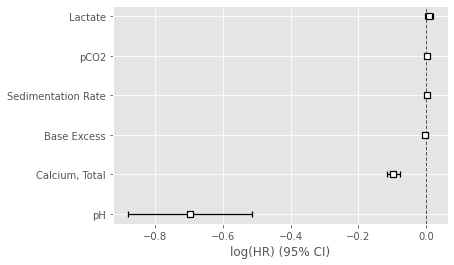

In [ ]:
# Fitting the model
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(final_df, id_col="stay_id", event_col="sepsis", start_col="start", stop_col="stop_time", show_progress=True)
ctv.print_summary()
ctv.plot()

In [ ]:
# We compare the existing model (with all the covariates) to the trivial model of no covariates using the likelihood ratio test.
ctv.log_likelihood_ratio_test()

<lifelines.StatisticalResult: None>
  degrees_freedom = 6
null_distribution = chi squared
        test_name = None

---
                           test_statistic      p  -log2(p)
log-likelihood ratio test          175.37 <0.005    114.56

Attempting prediction

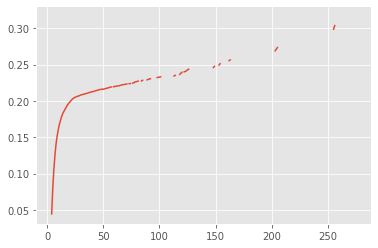

In [ ]:
b_hazard = pd.DataFrame({'baseline_hazard': 0}, index = np.arange(1, 480, 1))
b_hazard['baseline_hazard'] = ctv.baseline_cumulative_hazard_
b_hazard['baseline_hazard'].plot()


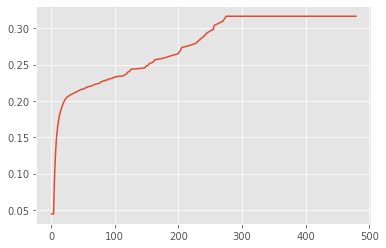

In [ ]:
b_hazard = b_hazard.interpolate(method='linear', limit_direction='both', axis=0)
b_hazard['baseline_hazard'].plot()

In [ ]:
b_hazard['stop_time'] = b_hazard.index
b_hazard

,baseline_hazard,stop_time
1,0.044546,1
2,0.044546,2
3,0.044546,3
4,0.044546,4
5,0.080337,5
...,...,...
475,0.316463,475
476,0.316463,476
477,0.316463,477
478,0.316463,478


In [ ]:
final_df_predict = final_df.copy()
final_df_predict['partial_hazard'] = ctv.predict_partial_hazard(final_df)
final_df_predict = final_df_predict.merge(b_hazard, left_on='stop_time', right_on='stop_time')
final_df_predict

,stay_id,stop_time,Base Excess,"Calcium, Total",Lactate,Sedimentation Rate,pCO2,pH,sepsis,start,partial_hazard,baseline_hazard
0,30000153,2,-3.000000,8.466598,1.300000,51.136232,45.00000,7.300000,False,0.0,1.064201,0.044546
1,30000646,2,-0.527634,7.800000,2.376382,51.136232,42.19789,7.377926,False,0.0,1.066544,0.044546
2,30001148,2,3.000000,8.466598,2.376382,51.136232,38.00000,7.390000,False,0.0,0.967451,0.044546
3,30002548,2,3.000000,8.466598,0.800000,51.136232,44.00000,7.410000,False,0.0,0.957878,0.044546
4,30003275,2,-0.527634,9.100000,2.376382,51.136232,42.19789,7.377926,False,0.0,0.940621,0.044546
...,...,...,...,...,...,...,...,...,...,...,...,...
216438,38710393,409,-0.527634,8.600000,2.376382,51.136232,42.19789,7.377926,False,386.0,0.987190,0.316463
216439,38710393,434,-0.527634,8.100000,2.376382,51.136232,42.19789,7.377926,False,409.0,1.036065,0.316463
216440,38710393,453,-0.527634,8.100000,2.376382,51.136232,42.19789,7.377926,False,434.0,1.036065,0.316463
216441,38761888,359,-0.527634,8.800000,2.376382,51.136232,42.19789,7.377926,False,335.0,0.968292,0.316463


In [ ]:
((final_df_predict['partial_hazard'] * final_df_predict['baseline_hazard']) > 0.5).sum()

6

Derived Tables

In [117]:
df = run_query(f'''
WITH cohort AS
(
  SELECT ie.subject_id, ie.hadm_id, ie.stay_id, ie.intime, ie.outtime, ie.first_careunit, ie.last_careunit
  -- DATE_DIFF truncates hour difference
  , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 10 THEN 1 ELSE 0 END AS exclude_short_stay
  , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
  , CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
  , CASE WHEN DATE_DIFF(sep.sofa_time, ie.intime, HOUR) < 4 THEN 1 ELSE 0 END AS exclude_early_sepsis
  FROM `physionet-data.mimic_icu.icustays` ie
  INNER JOIN `physionet-data.mimic_derived.age` age
      ON ie.hadm_id = age.hadm_id
  LEFT JOIN `physionet-data.mimic_derived.sepsis3` sep
      ON ie.stay_id = sep.stay_id
)
SELECT ct.subject_id, ct.hadm_id, ct.stay_id,  
ct.intime,
ct.outtime,
ct.first_careunit,
ct.last_careunit,
da.age,
dc.charlson_comorbidity_index,
ct.exclude_short_stay, ct.exclude_long_stay, ct.exclude_non_adult, ct.exclude_early_sepsis
FROM cohort ct
LEFT JOIN `physionet-data.mimic_derived.age`da
  ON ct.subject_id = da.subject_id
LEFT JOIN `physionet-data.mimic_derived.charlson` dc
  ON ct.subject_id = dc.subject_id
WHERE ct.subject_id = 10002495 
ORDER BY ct.stay_id
''')

display(df)

,subject_id,hadm_id,stay_id,intime,outtime,first_careunit,last_careunit,age,charlson_comorbidity_index,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,Coronary Care Unit (CCU),Coronary Care Unit (CCU),81,7,0,0,0,1


**Tests**



In [ ]:
ctv.predict_partial_hazard(final_df)

0         1.063318
1         1.070348
2         1.108776
3         1.060102
4         1.046200
            ...   
216437    0.977644
216438    0.958895
216439    0.968224
216440    0.940505
216441    0.958895
Length: 216442, dtype: float64

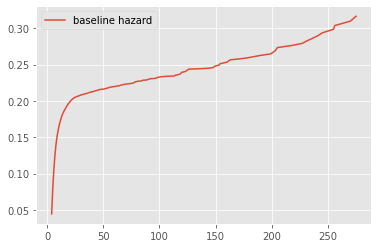

In [ ]:
ctv.baseline_cumulative_hazard_.plot()

In [ ]:
ctv.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Base Excess,-0.003397,0.996608,0.001709,-0.006748,-0.000047,0.993275,0.999953,0.0,-1.987477,4.686951e-02,4.415206
"Calcium, Total",-0.096820,0.907719,0.009544,-0.115526,-0.078115,0.890898,0.924858,0.0,-10.144936,3.490070e-24,77.923018
Lactate,0.008237,1.008271,0.005520,-0.002583,0.019056,0.997421,1.019239,0.0,1.492132,1.356644e-01,2.881886
Sedimentation Rate,0.001806,1.001808,0.003191,-0.004447,0.008060,0.995563,1.008093,0.0,0.566171,5.712773e-01,0.807737
pCO2,0.002781,1.002785,0.000841,0.001133,0.004429,1.001133,1.004439,0.0,3.306885,9.433953e-04,10.049850
pH,-0.694518,0.499315,0.093419,-0.877616,-0.511419,0.415773,0.599644,0.0,-7.434402,1.050419e-13,43.114100


In [ ]:
ctv.baseline_survival_

,baseline survival
4,0.956428
5,0.922799
6,0.898520
7,0.880821
8,0.867602
...,...
245,0.745523
255,0.741895
256,0.738134
270,0.733632


In [ ]:
ctv.baseline_cumulative_hazard_

,baseline hazard
4,0.044550
5,0.080343
6,0.107006
7,0.126901
8,0.142023
...,...
245,0.293670
255,0.298547
256,0.303630
270,0.309748


In [ ]:
df = run_query(f'''
SELECT ie.subject_id, ie.hadm_id, ie.stay_id, ie.intime, ie.outtime
, (ie.intime - ie.outtime) AS DateDiff
, DATE_DIFF(ie.outtime, ie.intime, HOUR) AS DD
-- DATE_DIFF truncates hour difference
, CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 8 THEN 1 ELSE 0 END AS exclude_short_stay
, CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
, CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
FROM `physionet-data.mimic_icu.icustays` ie
INNER JOIN `physionet-data.mimic_derived.age` age
    ON ie.hadm_id = age.hadm_id
WHERE ie.subject_id IN ({id_str})
''')
display(df)

,subject_id,hadm_id,stay_id,intime,outtime,DateDiff,DD,exclude_short_stay,exclude_long_stay,exclude_non_adult
0,10001884,26184834,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,0-0 -9 -4:7:25,220,0,0,0
1,10003400,20214994,32128372,2137-02-25 23:37:19,2137-03-10 21:29:36,0-0 -12 -21:52:17,310,0,0,0
2,10003400,23559586,38383343,2137-08-17 17:36:37,2137-09-02 19:17:11,0-0 -16 -1:40:34,386,0,0,0
3,10003400,23559586,34577403,2137-08-10 19:54:51,2137-08-13 17:54:54,0-0 -2 -22:0:3,70,0,0,0
4,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,0-0 -5 -2:6:1,122,0,0,0
5,10005866,20364112,34170353,2149-10-02 12:48:08,2149-10-04 17:48:36,0-0 -2 -5:0:28,53,0,0,0
6,10002223,22494570,39638202,2158-01-15 08:01:49,2158-01-16 15:19:24,0-0 -1 -7:17:35,31,0,0,0
7,10000032,29079034,39553978,2180-07-23 14:00:00,2180-07-23 23:50:47,0-0 0 -9:50:47,9,0,0,0
8,10002443,21329021,35044219,2183-10-18 00:47:00,2183-10-20 18:48:03,0-0 -2 -18:1:3,66,0,0,0


In [ ]:
df = run_query(f'''
SELECT ie.subject_id, ie.hadm_id, ie.stay_id, ie.intime, ie.outtime, sep.sofa_time, sep.sofa_score, sep.sepsis3
, (ie.intime - ie.outtime) AS DateDiff
, DATE_DIFF(ie.outtime, ie.intime, HOUR) AS DD
-- DATE_DIFF truncates hour difference
, CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 10 THEN 1 ELSE 0 END AS exclude_short_stay
, CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
, CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
, DATE_DIFF(sep.sofa_time, ie.intime, HOUR) AS DD
, CASE WHEN DATE_DIFF(sep.sofa_time, ie.intime, HOUR) < 4 THEN 1 ELSE 0 END AS exclude_early_sepsis
FROM `physionet-data.mimic_icu.icustays` ie
INNER JOIN `physionet-data.mimic_derived.age` age
    ON ie.hadm_id = age.hadm_id
LEFT JOIN `physionet-data.mimic_derived.sepsis3` sep
    ON ie.stay_id = sep.stay_id
''')
display(df)

,subject_id,hadm_id,stay_id,intime,outtime,sofa_time,sofa_score,sepsis3,DateDiff,DD,exclude_short_stay,exclude_long_stay,exclude_non_adult,DD_1,exclude_early_sepsis
0,17310431,22485233,37047409,2110-09-06 08:59:33,2110-09-07 23:05:39,2110-09-07 04:00:00,2.0,True,0-0 -1 -14:6:6,39,0,0,0,20.0,0
1,14895375,24753602,30003275,2110-06-28 17:26:48,2110-06-29 14:10:52,2110-06-29 05:00:00,2.0,True,0-0 0 -20:44:4,21,0,0,0,12.0,0
2,13299333,27282813,39687318,2114-05-29 08:44:18,2114-05-30 22:05:50,2114-05-29 22:00:00,3.0,True,0-0 -1 -13:21:32,38,0,0,0,14.0,0
3,14147585,27195136,33798402,2111-02-19 15:34:46,2111-02-21 18:08:52,2111-02-20 05:00:00,5.0,True,0-0 -2 -2:34:6,51,0,0,0,14.0,0
4,15554295,27705504,39577681,2110-03-09 03:55:00,2110-03-16 18:15:59,2110-03-11 02:00:00,10.0,True,0-0 -7 -14:20:59,183,0,0,0,47.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76535,17866064,28315320,36746030,2196-09-27 08:13:28,2196-09-30 12:37:48,2196-09-27 19:00:00,3.0,True,0-0 -3 -4:24:20,76,0,0,0,11.0,0
76536,19516774,25638763,36663547,2201-12-30 13:46:34,2201-12-31 18:53:38,2201-12-31 00:00:00,2.0,True,0-0 -1 -5:7:4,29,0,0,0,11.0,0
76537,15365753,21499379,39629292,2197-09-08 16:23:00,2197-09-16 21:48:46,2197-09-09 03:00:00,2.0,True,0-0 -8 -5:25:46,197,0,0,0,11.0,0
76538,10800546,28248634,36782769,2198-01-15 19:52:00,2198-01-16 12:36:39,2198-01-16 06:00:00,4.0,True,0-0 0 -16:44:39,17,0,0,0,11.0,0


In [ ]:
df = run_query(f'''
SELECT ie.subject_id, ie.hadm_id, ie.stay_id
-- DATE_DIFF truncates hour difference
, CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 10 THEN 1 ELSE 0 END AS exclude_short_stay
, CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
, CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
, CASE WHEN DATE_DIFF(sep.sofa_time, ie.intime, HOUR) < 4 THEN 1 ELSE 0 END AS exclude_early_sepsis
FROM `physionet-data.mimic_icu.icustays` ie
INNER JOIN `physionet-data.mimic_derived.age` age
    ON ie.hadm_id = age.hadm_id
LEFT JOIN `physionet-data.mimic_derived.sepsis3` sep
    ON ie.stay_id = sep.stay_id
''')
display(df)

,subject_id,hadm_id,stay_id,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,16233333,20104005,39550370,0,0,0,0
1,18818836,25852913,34879697,0,0,0,0
2,10474526,21021060,30384015,0,0,0,1
3,11245028,27889421,33064307,0,0,0,0
4,19856829,23266513,38811029,0,0,0,0
...,...,...,...,...,...,...,...
76535,16464652,21685914,39045781,0,0,0,1
76536,18451791,28897092,32688519,0,0,0,0
76537,17715495,20406663,38915774,0,0,0,1
76538,14123938,26523563,39332229,0,0,0,0


In [ ]:
df_excl_length_stay = df[(df['exclude_long_stay']==0) & (df['exclude_short_stay']==0)]
df_excl_length_stay

,subject_id,hadm_id,stay_id,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,16233333,20104005,39550370,0,0,0,0
1,18818836,25852913,34879697,0,0,0,0
2,10474526,21021060,30384015,0,0,0,1
3,11245028,27889421,33064307,0,0,0,0
4,19856829,23266513,38811029,0,0,0,0
...,...,...,...,...,...,...,...
76535,16464652,21685914,39045781,0,0,0,1
76536,18451791,28897092,32688519,0,0,0,0
76537,17715495,20406663,38915774,0,0,0,1
76538,14123938,26523563,39332229,0,0,0,0


In [ ]:
df_excl_length_stay_and_early_sepsis = df_excl_length_stay[df_excl_length_stay['exclude_early_sepsis']==0]
df_excl_length_stay_and_early_sepsis

,subject_id,hadm_id,stay_id,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,16233333,20104005,39550370,0,0,0,0
1,18818836,25852913,34879697,0,0,0,0
3,11245028,27889421,33064307,0,0,0,0
4,19856829,23266513,38811029,0,0,0,0
5,16006168,22277686,30927169,0,0,0,0
...,...,...,...,...,...,...,...
76533,11027112,29265965,34473473,0,0,0,0
76534,14891600,22868751,37689325,0,0,0,0
76536,18451791,28897092,32688519,0,0,0,0
76538,14123938,26523563,39332229,0,0,0,0


In [ ]:
len(df_excl_length_stay_and_early_sepsis['hadm_id'].unique())

50709

In [ ]:
df[df['exclude_long_stay']==1]

,subject_id,hadm_id,stay_id,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
342,13105864,27810235,37820266,0,1,0,1
346,13337664,26050368,37485420,0,1,0,0
400,16504173,27405913,32144102,0,1,0,0
405,16504173,25082363,35859388,0,1,0,1
412,15983067,24908776,32421408,0,1,0,1
...,...,...,...,...,...,...,...
76344,18775105,21775436,33951736,0,1,0,0
76426,17417573,24710404,36358936,0,1,0,1
76441,11312502,25289892,33521917,0,1,0,1
76495,12648465,22702738,32471162,0,1,0,1


In [ ]:
df[df['exclude_short_stay']==1]

,subject_id,hadm_id,stay_id,intime,outtime,sofa_time,sofa_score,sepsis3,DateDiff,DD,exclude_short_stay,exclude_short_stay_1,exclude_non_adult,DD_1,exclude_early_sepsis
242,10192984,22777564,36933726,2117-10-15 16:08:11,2117-10-16 00:57:37,2117-10-15 16:00:00,4.0,True,0-0 0 -8:49:26,8,1,0,0,0.0,1
1741,15361018,23592768,31324591,2145-02-12 00:50:32,2145-02-12 05:21:02,2145-02-12 00:00:00,3.0,True,0-0 0 -4:30:30,5,1,0,0,0.0,1
2051,13411236,22483382,34784253,2153-06-08 04:00:00,2153-06-08 13:13:17,2153-06-08 04:00:00,2.0,True,0-0 0 -9:13:17,9,1,0,0,0.0,1
3841,19591114,25773196,34571630,2184-07-28 20:12:00,2184-07-29 05:06:30,2184-07-28 20:00:00,2.0,True,0-0 0 -8:54:30,9,1,0,0,0.0,1
4181,18068560,20525607,37635150,2197-08-06 13:12:09,2197-08-06 18:46:40,2197-08-06 13:00:00,4.0,True,0-0 0 -5:34:31,5,1,0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73153,14094109,23109693,38886407,2133-03-13 13:14:00,2133-03-13 22:31:43,2133-03-13 20:00:00,2.0,True,0-0 0 -9:17:43,9,1,0,0,7.0,0
73435,18070887,23997562,39982932,2148-01-23 05:54:00,2148-01-23 13:00:44,2148-01-23 12:00:00,3.0,True,0-0 0 -7:6:44,8,1,0,0,7.0,0
74047,18338007,23809077,38201844,2198-08-28 05:47:00,2198-08-28 13:20:37,2198-08-28 12:00:00,2.0,True,0-0 0 -7:33:37,8,1,0,0,7.0,0
74800,13411502,28943160,34436131,2177-05-27 09:59:00,2177-05-27 18:27:07,2177-05-27 17:00:00,2.0,True,0-0 0 -8:28:7,9,1,0,0,8.0,0


In [ ]:
df[df['exclude_early_sepsis']==0]

,subject_id,hadm_id,stay_id,intime,outtime,sofa_time,sofa_score,sepsis3,DateDiff,DD,exclude_short_stay,exclude_short_stay_1,exclude_non_adult,DD_1,exclude_early_sepsis
0,17310431,22485233,37047409,2110-09-06 08:59:33,2110-09-07 23:05:39,2110-09-07 04:00:00,2.0,True,0-0 -1 -14:6:6,39,0,0,0,20.0,0
1,14895375,24753602,30003275,2110-06-28 17:26:48,2110-06-29 14:10:52,2110-06-29 05:00:00,2.0,True,0-0 0 -20:44:4,21,0,0,0,12.0,0
2,13299333,27282813,39687318,2114-05-29 08:44:18,2114-05-30 22:05:50,2114-05-29 22:00:00,3.0,True,0-0 -1 -13:21:32,38,0,0,0,14.0,0
3,14147585,27195136,33798402,2111-02-19 15:34:46,2111-02-21 18:08:52,2111-02-20 05:00:00,5.0,True,0-0 -2 -2:34:6,51,0,0,0,14.0,0
4,15554295,27705504,39577681,2110-03-09 03:55:00,2110-03-16 18:15:59,2110-03-11 02:00:00,10.0,True,0-0 -7 -14:20:59,183,0,0,0,47.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76535,17866064,28315320,36746030,2196-09-27 08:13:28,2196-09-30 12:37:48,2196-09-27 19:00:00,3.0,True,0-0 -3 -4:24:20,76,0,0,0,11.0,0
76536,19516774,25638763,36663547,2201-12-30 13:46:34,2201-12-31 18:53:38,2201-12-31 00:00:00,2.0,True,0-0 -1 -5:7:4,29,0,0,0,11.0,0
76537,15365753,21499379,39629292,2197-09-08 16:23:00,2197-09-16 21:48:46,2197-09-09 03:00:00,2.0,True,0-0 -8 -5:25:46,197,0,0,0,11.0,0
76538,10800546,28248634,36782769,2198-01-15 19:52:00,2198-01-16 12:36:39,2198-01-16 06:00:00,4.0,True,0-0 0 -16:44:39,17,0,0,0,11.0,0


In [ ]:
df = run_query(f'''
SELECT ie.subject_id, ie.hadm_id, ie.stay_id
-- DATE_DIFF truncates hour difference
, CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 10 THEN 1 ELSE 0 END AS exclude_short_stay
, CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
, CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
, CASE WHEN DATE_DIFF(sep.sofa_time, ie.intime, HOUR) < 4 THEN 1 ELSE 0 END AS exclude_early_sepsis
FROM `physionet-data.mimic_icu.icustays` ie
INNER JOIN `physionet-data.mimic_derived.age` age
    ON ie.hadm_id = age.hadm_id
LEFT JOIN `physionet-data.mimic_derived.sepsis3` sep
    ON ie.stay_id = sep.stay_id
''')
display(df)


df = run_query(f'''
WITH rates AS
(
  SELECT DISTINCT a.stay_id, a.first_heart_rate
  , CASE WHEN a.first_heart_rate > 110 THEN 1 ELSE 0 END AS exclude_first_heart_rate
  FROM
  (SELECT ce.subject_id, ce.stay_id, ce.charttime, ce.valuenum
  , FIRST_VALUE(ce.valuenum) OVER (PARTITION BY ce.stay_id ORDER BY ce.charttime) AS first_heart_rate
  FROM `physionet-data.mimic_icu.chartevents` ce
  WHERE ce.subject_id IN ({id_str}) AND ce.itemid = 220045) a
)
SELECT rh.stay_id, rt.first_heart_rate, rt.exclude_first_heart_rate, rh.first_heart_rhythm, rh.exclude_first_heart_rhythm
FROM  (SELECT DISTINCT b.stay_id, b.first_heart_rhythm
      , CASE WHEN b.first_heart_rhythm = "AF (Atrial Fibrillation)" THEN 1 ELSE 0 END AS exclude_first_heart_rhythm
      FROM
      (SELECT ce.subject_id, ce.stay_id, ce.charttime, ce.value
      , FIRST_VALUE(ce.value) OVER (PARTITION BY ce.stay_id ORDER BY ce.charttime) AS first_heart_rhythm
      FROM `physionet-data.mimic_icu.chartevents` ce
      INNER JOIN `physionet-data.mimic_icu.d_items` di
            ON ce.itemid = di.itemid
      WHERE ce.subject_id IN ({id_str}) AND ce.itemid = 220048) b) rh
INNER JOIN rates rt
    ON rt.stay_id = rh.stay_id
''')
display(df)

In [ ]:
# the below variables are used throughout the notebook - do not change them!
subject_ids = [10000032, 10001884, 10002223, 10002495, 10002443, 10003400, 10005866]
id_str = ','.join([str(s) for s in subject_ids])

item_ids = [220052, 220045, 220227, 220050, 220051, 220210, 223762, 227013, 228232, 
            223835, 220546, 220228, 220545, 220615, 225690, 225651, 227467, 227466, 
            220587, 225612, 220621, 227442, 225624, 220635, 220602, 227446, 227429, 
            227468, 227444, 220580, 227443, 224719, 229571]

itemid_str = ','.join([str(s) for s in item_ids])


labitem_ids = [50813, 50893, 51288, 50820, 50818, 50802]

labitemid_str = ','.join([str(s) for s in labitem_ids])

In [ ]:

df = run_query(f'''
WITH cohort AS
(
  SELECT ie.subject_id, ie.hadm_id, ie.stay_id, ie.intime, ie.outtime
  -- DATE_DIFF truncates hour difference
  , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 10 THEN 1 ELSE 0 END AS exclude_short_stay
  , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
  , CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
  , CASE WHEN DATE_DIFF(sep.sofa_time, ie.intime, HOUR) < 4 THEN 1 ELSE 0 END AS exclude_early_sepsis
  FROM `physionet-data.mimic_icu.icustays` ie
  INNER JOIN `physionet-data.mimic_derived.age` age
      ON ie.hadm_id = age.hadm_id
  LEFT JOIN `physionet-data.mimic_derived.sepsis3` sep
      ON ie.stay_id = sep.stay_id
)

SELECT ct.subject_id, ct.hadm_id, ct.stay_id,  
ct.intime,
ct.outtime,
ce.itemid,
ce.charttime,
ci.label,
ce.value,
ce.valuenum,
ce.valueuom,
ct.exclude_short_stay, ct.exclude_long_stay, ct.exclude_non_adult, ct.exclude_early_sepsis
FROM cohort ct
LEFT JOIN `physionet-data.mimic_icu.chartevents`ce
  ON ct.stay_id = ce.stay_id
LEFT JOIN `physionet-data.mimic_icu.d_items` ci
  ON ce.itemid = ci.itemid
WHERE ct.subject_id = 10002495 AND ce.itemid IN ({itemid_str}) 
ORDER BY ce.charttime

''')

display(df)

,subject_id,hadm_id,stay_id,intime,outtime,itemid,charttime,label,value,valuenum,valueuom,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,220210,2141-05-22 20:18:00,Respiratory Rate,26,26.0,insp/min,0,0,0,1
1,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,220045,2141-05-22 20:18:00,Heart Rate,114,114.0,bpm,0,0,0,1
2,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,220210,2141-05-22 20:32:00,Respiratory Rate,26,26.0,insp/min,0,0,0,1
3,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,220045,2141-05-22 20:32:00,Heart Rate,115,115.0,bpm,0,0,0,1
4,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,220045,2141-05-22 21:00:00,Heart Rate,108,108.0,bpm,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,220045,2141-05-27 19:00:00,Heart Rate,85,85.0,bpm,0,0,0,1
568,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,220210,2141-05-27 20:00:00,Respiratory Rate,21,21.0,insp/min,0,0,0,1
569,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,220045,2141-05-27 20:00:00,Heart Rate,86,86.0,bpm,0,0,0,1
570,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,220210,2141-05-27 21:00:00,Respiratory Rate,19,19.0,insp/min,0,0,0,1


In [ ]:

df = run_query(f'''
WITH cohort AS
(
  SELECT ie.subject_id, ie.hadm_id, ie.stay_id, ie.intime, ie.outtime
  -- DATE_DIFF truncates hour difference
  , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 10 THEN 1 ELSE 0 END AS exclude_short_stay
  , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
  , CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
  , CASE WHEN DATE_DIFF(sep.sofa_time, ie.intime, HOUR) < 4 THEN 1 ELSE 0 END AS exclude_early_sepsis
  FROM `physionet-data.mimic_icu.icustays` ie
  INNER JOIN `physionet-data.mimic_derived.age` age
      ON ie.hadm_id = age.hadm_id
  LEFT JOIN `physionet-data.mimic_derived.sepsis3` sep
      ON ie.stay_id = sep.stay_id
)

SELECT ct.subject_id, ct.hadm_id, ct.stay_id,  
ct.intime,
ct.outtime,
le.itemid,
le.charttime,
le.value,
le.valuenum,
li.label,
ct.exclude_short_stay, ct.exclude_long_stay, ct.exclude_non_adult, ct.exclude_early_sepsis
FROM cohort ct
LEFT JOIN `physionet-data.mimic_hosp.labevents` le
  ON ct.hadm_id = le.hadm_id
LEFT JOIN `physionet-data.mimic_hosp.d_labitems` li
  ON le.itemid = li.itemid
WHERE le.itemid IN ({labitemid_str}) AND ct.intime < le.charttime AND le.charttime < ct.outtime
ORDER BY le.charttime

''')

display(df)

,subject_id,hadm_id,stay_id,intime,outtime,itemid,charttime,value,valuenum,label,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,18106347,24305596,30588857,2110-01-11 10:16:06,2110-01-12 17:17:47,50802,2110-01-11 10:22:00,1,1.00,Base Excess,0,0,0,0
1,18106347,24305596,30588857,2110-01-11 10:16:06,2110-01-12 17:17:47,50818,2110-01-11 10:22:00,47,47.00,pCO2,0,0,0,0
2,18106347,24305596,30588857,2110-01-11 10:16:06,2110-01-12 17:17:47,50820,2110-01-11 10:22:00,7.37,7.37,pH,0,0,0,0
3,18106347,24305596,30588857,2110-01-11 10:16:06,2110-01-12 17:17:47,50818,2110-01-11 11:05:00,41,41.00,pCO2,0,0,0,0
4,18106347,24305596,30588857,2110-01-11 10:16:06,2110-01-12 17:17:47,50820,2110-01-11 11:05:00,7.38,7.38,pH,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1833042,14239401,21199923,35906940,2211-05-01 06:59:19,2211-05-10 22:51:06,50820,2211-05-09 02:48:00,7.49,7.49,pH,0,0,0,0
1833043,14239401,21199923,35906940,2211-05-01 06:59:19,2211-05-10 22:51:06,50802,2211-05-09 02:48:00,9,9.00,Base Excess,0,0,0,0
1833044,14239401,21199923,35906940,2211-05-01 06:59:19,2211-05-10 22:51:06,50818,2211-05-09 02:48:00,44,44.00,pCO2,0,0,0,0
1833045,14239401,21199923,35906940,2211-05-01 06:59:19,2211-05-10 22:51:06,50893,2211-05-10 03:59:00,8.5,8.50,"Calcium, Total",0,0,0,0


In [ ]:

df = run_query(f'''
WITH cohort AS
(
  SELECT ie.subject_id, ie.hadm_id, ie.stay_id, ie.intime, ie.outtime, ie.first_careunit, ie.last_careunit
  -- DATE_DIFF truncates hour difference
  , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 10 THEN 1 ELSE 0 END AS exclude_short_stay
  , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
  , CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
  , CASE WHEN DATE_DIFF(sep.sofa_time, ie.intime, HOUR) < 4 THEN 1 ELSE 0 END AS exclude_early_sepsis
  FROM `physionet-data.mimic_icu.icustays` ie
  INNER JOIN `physionet-data.mimic_derived.age` age
      ON ie.hadm_id = age.hadm_id
  LEFT JOIN `physionet-data.mimic_derived.sepsis3` sep
      ON ie.stay_id = sep.stay_id
)
SELECT ct.subject_id, ct.hadm_id, ct.stay_id,  
ct.intime,
ct.outtime,
ct.first_careunit,
ct.last_careunit,
da.age,
dc.charlson_comorbidity_index,
ct.exclude_short_stay, ct.exclude_long_stay, ct.exclude_non_adult, ct.exclude_early_sepsis
FROM cohort ct
LEFT JOIN `physionet-data.mimic_derived.age`da
  ON ct.subject_id = da.subject_id
LEFT JOIN `physionet-data.mimic_derived.charlson` dc
  ON ct.subject_id = dc.subject_id
WHERE ct.subject_id = 10002495 
ORDER BY ct.stay_id
''')

display(df)

,subject_id,hadm_id,stay_id,intime,outtime,first_careunit,last_careunit,age,charlson_comorbidity_index,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,Coronary Care Unit (CCU),Coronary Care Unit (CCU),81,7,0,0,0,1


In [ ]:
df['label_1'].unique()

array(['Lactate', 'Calcium, Total', 'pCO2', 'Base Excess', 'pH'],
      dtype=object)

In [ ]:
df[df['sofa_score'].isna()]

,subject_id,hadm_id,stay_id,intime,outtime,sofa_time,sofa_score,sepsis3,DateDiff,DD,exclude_short_stay,exclude_short_stay_1,exclude_non_adult
698,16233333,20104005,39550370,2118-09-25 15:52:17,2118-09-26 10:26:18,NaT,NaN,None,0-0 0 -18:34:1,19,1,1,0
699,18818836,25852913,34879697,2110-09-21 11:26:32,2110-09-21 22:41:05,NaT,NaN,None,0-0 0 -11:14:33,11,1,1,0
700,11245028,27889421,33064307,2110-11-12 06:01:00,2110-11-12 18:23:43,NaT,NaN,None,0-0 0 -12:22:43,12,1,1,0
701,19856829,23266513,38811029,2110-12-20 03:42:00,2110-12-20 16:56:04,NaT,NaN,None,0-0 0 -13:14:4,13,1,1,0
702,16006168,22277686,30927169,2110-01-21 05:50:00,2110-01-25 20:59:23,NaT,NaN,None,0-0 -4 -15:9:23,111,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42444,11027112,29265965,34473473,2206-10-26 00:44:48,2206-10-27 15:32:23,NaT,NaN,None,0-0 -1 -14:47:35,39,1,1,0
42445,14891600,22868751,37689325,2206-02-24 13:40:00,2206-02-25 15:22:09,NaT,NaN,None,0-0 -1 -1:42:9,26,1,1,0
42446,18451791,28897092,32688519,2211-01-05 10:59:50,2211-01-06 17:00:09,NaT,NaN,None,0-0 -1 -6:0:19,31,1,1,0
42447,14123938,26523563,39332229,2208-07-06 08:34:09,2208-07-07 18:33:13,NaT,NaN,None,0-0 -1 -9:59:4,34,1,1,0
